In [31]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [32]:
fetcher = DataFetcher(DB_PARAMS)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


In [34]:
df = fetcher.fetch_data(
      regressors=[
       'avg_default_verbolizer', 
       'avg_shrink_verbolizer',
       'max_abs_default',
       'max_abs_shrink',
        'max_default_verbolizer',
        'max_shrink_verbolizer',
        'min_default_verbolizer',
        'min_shrink_verbolizer'
       ],
   prepare_fixed_effects=True
)

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:196: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:211: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  companies_df = pd.read_sql_query(query, conn)


In [ ]:
# Reset index to make 'company' and 'date' columns
df_reset = df.reset_index()

# Find duplicates based on (company, date)
duplicates = df_reset[df_reset.duplicated(subset=['company', 'date'], keep=False)]

# Display all duplicated rows
print(duplicates.sort_values(by=['company', 'date']))


Empty DataFrame
Columns: [company, date, avg_default_verbolizer, avg_shrink_verbolizer, max_default_verbolizer, max_shrink_verbolizer, min_default_verbolizer, min_shrink_verbolizer, two_day_r, three_day_r, four_day_r, five_day_r, six_day_r, seven_day_r, full_q_r, two_day_e_r, three_day_e_r, four_day_e_r, five_day_e_r, six_day_e_r, seven_day_e_r, full_q_e_r, two_day_abn_r, three_day_abn_r, four_day_abn_r, five_day_abn_r, six_day_abn_r, seven_day_abn_r, full_q_abn_r, two_day_r_vol, three_day_r_vol, four_day_r_vol, five_day_r_vol, six_day_r_vol, seven_day_r_vol, full_q_r_vol, filing_rank]
Index: []

[0 rows x 37 columns]


In [ ]:
dupe_counts = (
    df_reset.groupby(['company', 'date'])
    .size()
    .reset_index(name='count')
    .query('count > 1')
)
print(dupe_counts)


Empty DataFrame
Columns: [company, date, count]
Index: []


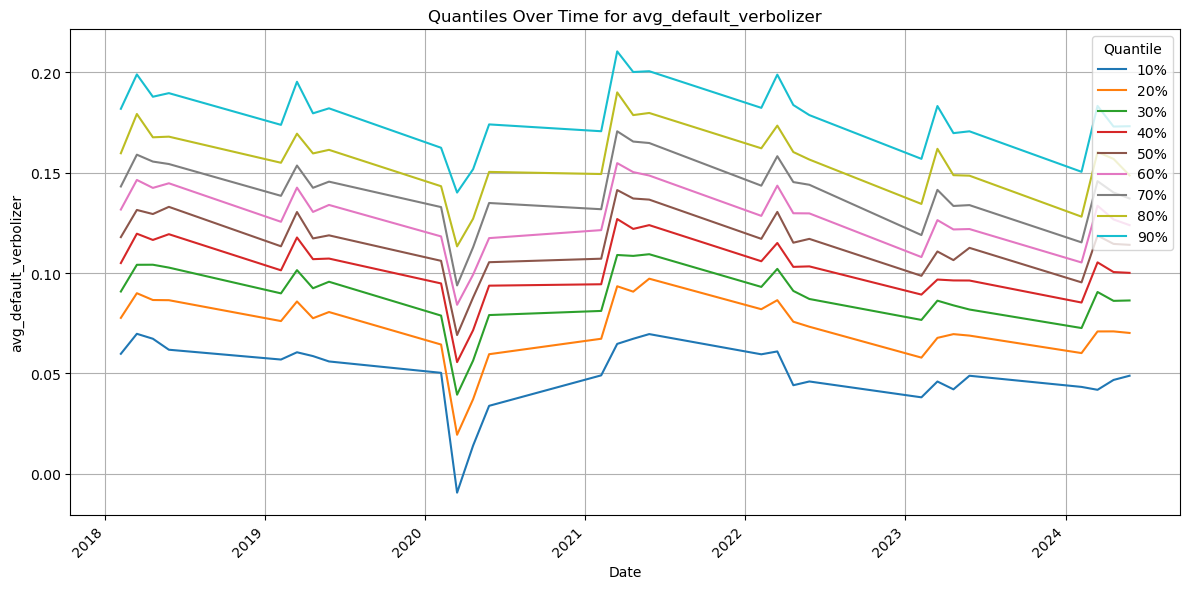

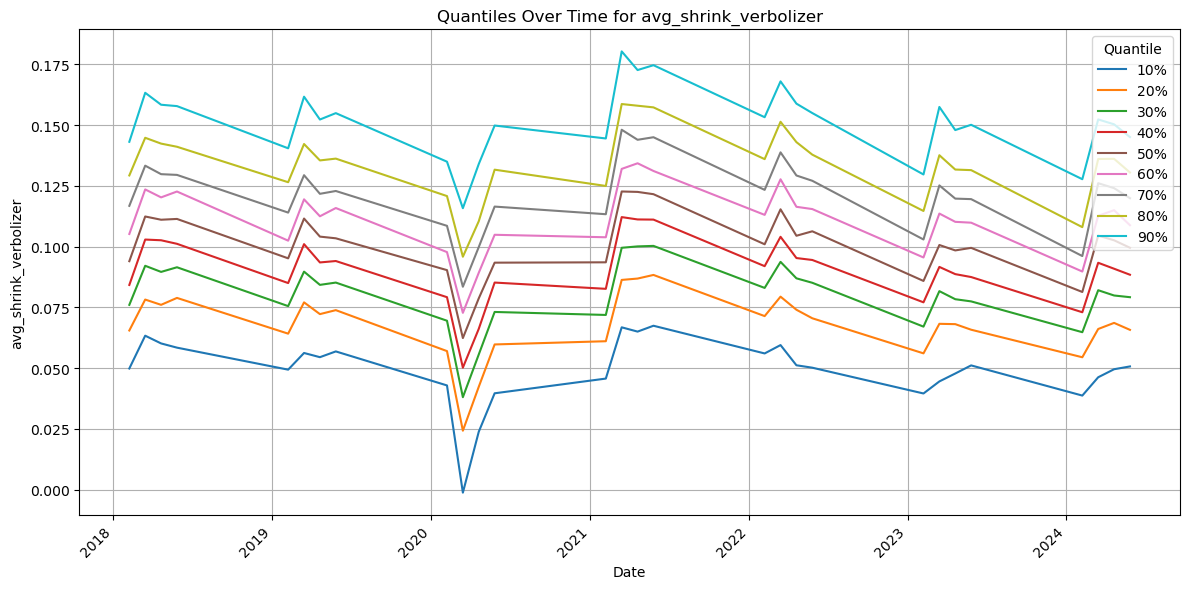

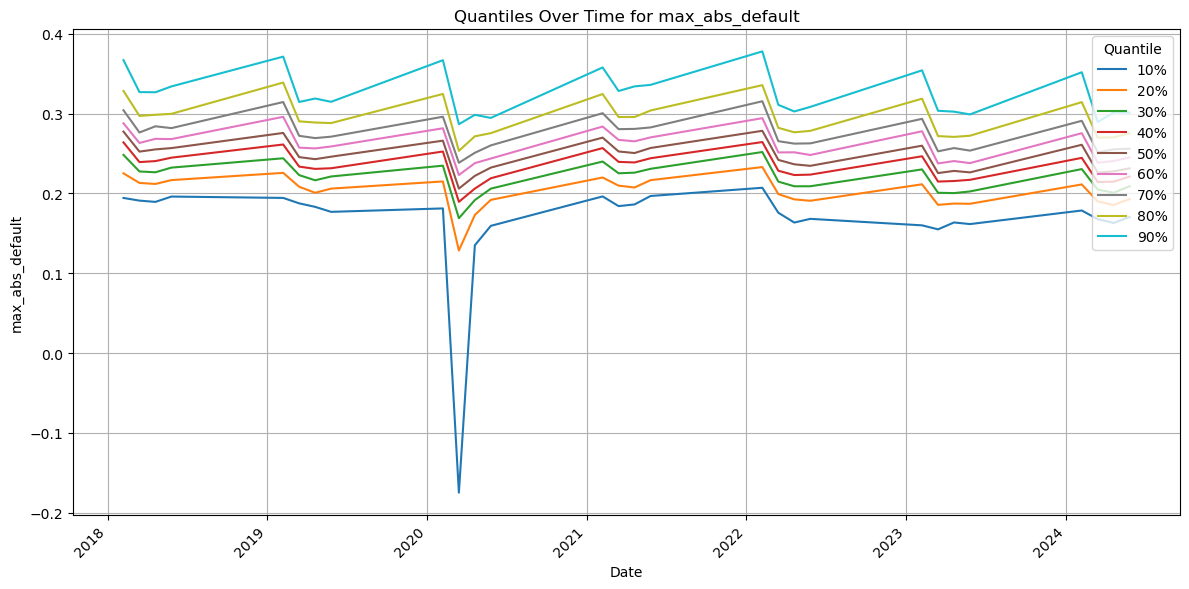

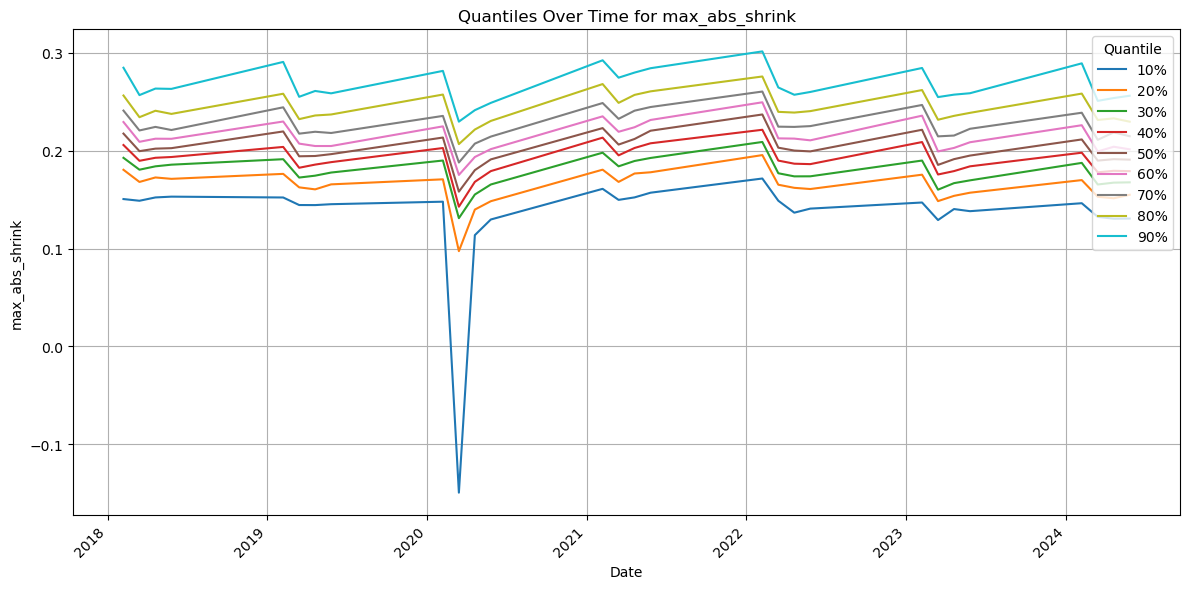

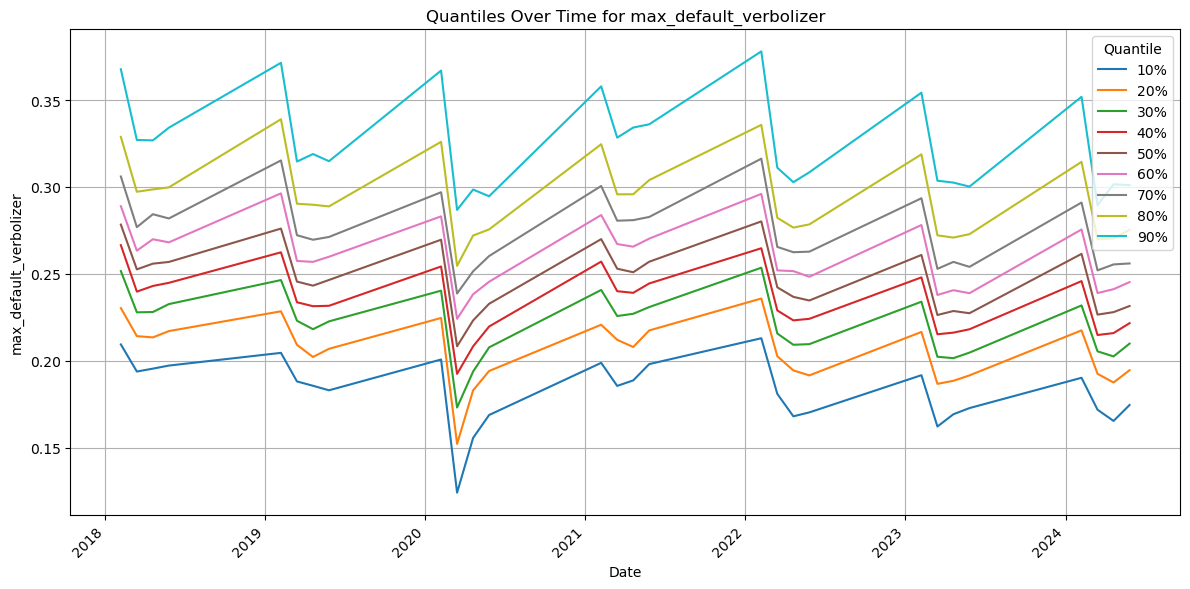

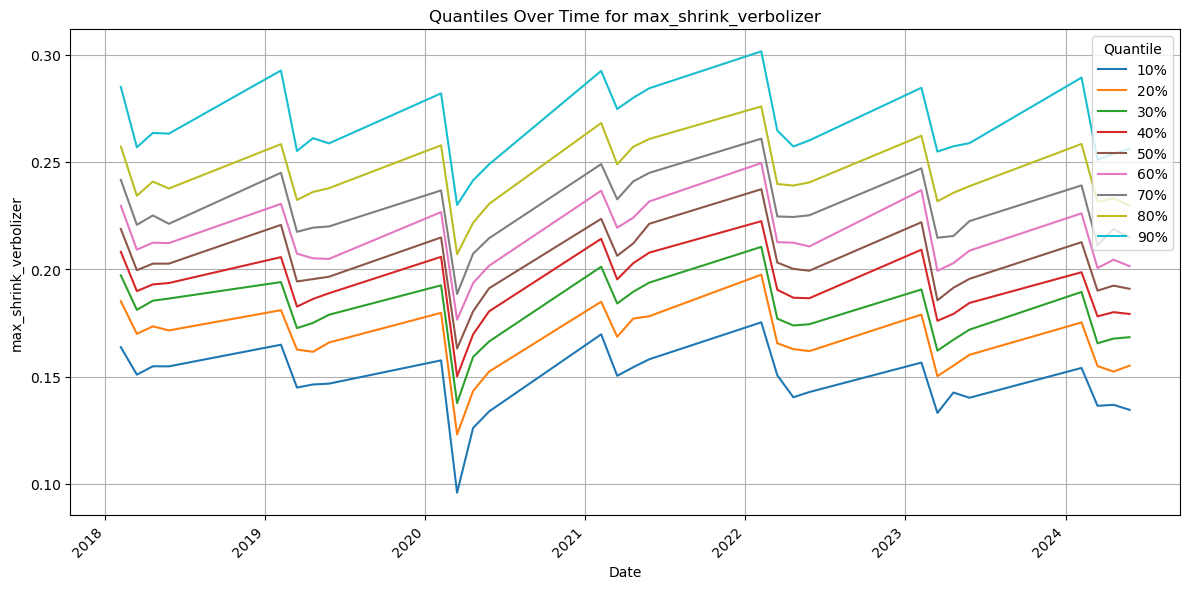

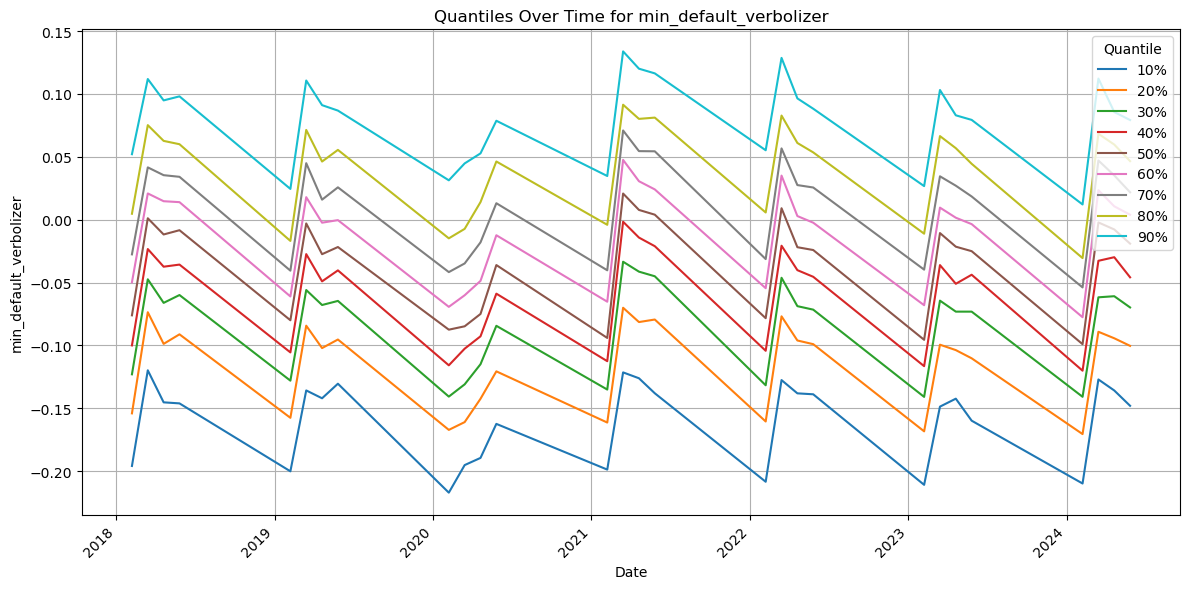

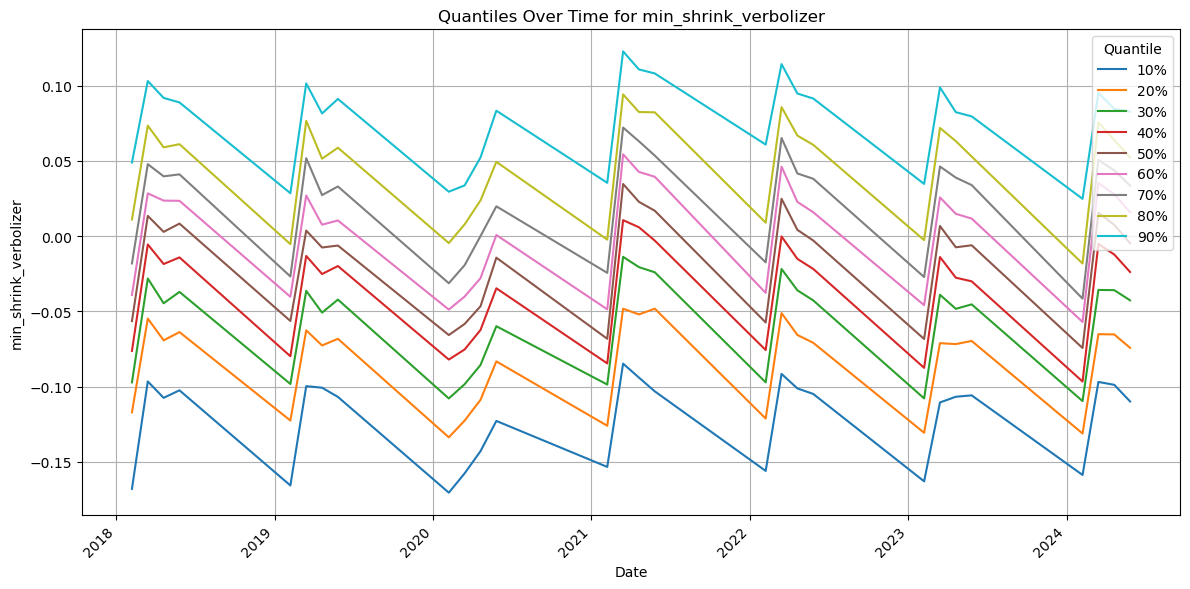

In [39]:
# Define target columns and quantile levels
cols =[
       'avg_default_verbolizer', 
       'avg_shrink_verbolizer',
       'max_abs_default',
       'max_abs_shrink',
        'max_default_verbolizer',
        'max_shrink_verbolizer',
        'min_default_verbolizer',
        'min_shrink_verbolizer'
       ]
quantile_levels = np.linspace(0.1, 0.9, 9)

# Reset index to make 'date' a column
df_reset = df.reset_index()

# For each column: compute quantiles across companies for each date
for col in cols:
    # Pivot: rows = date, columns = company, values = col
    data = df_reset.pivot(index='date', columns='company', values=col)

    # Compute quantiles row-wise (across companies)
    quantiles_df = pd.DataFrame(
        [data.quantile(q, axis=1) for q in quantile_levels],
        index=[f'{int(q*100)}%' for q in quantile_levels]
    ).T  # shape: (n_dates × 9)

    # Plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, 9))

    for i, q_label in enumerate(quantiles_df.columns):
        plt.plot(
            quantiles_df.index, 
            quantiles_df[q_label], 
            label=q_label, 
            color=colors[i]
        )

    plt.title(f'Quantiles Over Time for {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend(title='Quantile', loc='upper right')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
fetcher.sectors

{'Technology': 92,
 'Industrials': 86,
 'Financial Services': 85,
 'Healthcare': 66,
 'Consumer Cyclical': 58,
 'Consumer Defensive': 40,
 'Real Estate': 32,
 'Utilities': 32,
 'Energy': 30,
 'Basic Materials': 23,
 'Communication Services': 22}

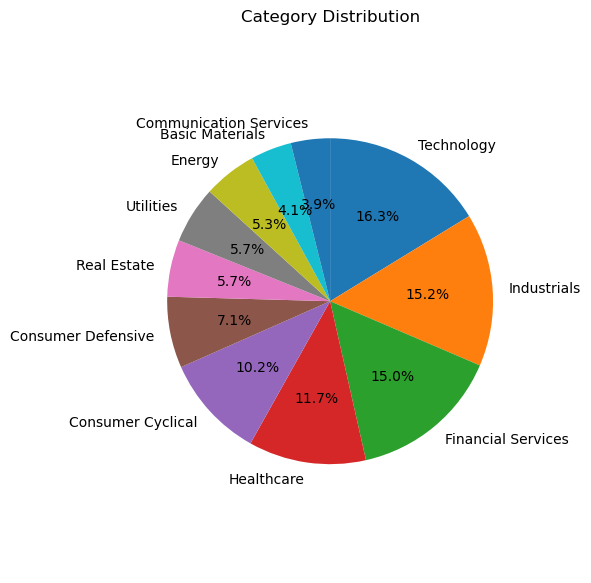

In [ ]:
labels = list(fetcher.sectors.keys())
sizes = list(fetcher.sectors.values())

# Create pie chart with percentage labels
plt.figure(figsize=(6, 6))
plt.pie( 
    sizes,
    labels=labels,
    autopct='%1.1f%%',     # Format for percentage
    startangle=90,         # Rotate start position
    counterclock=False     # Clockwise direction
)

plt.title("Category Distribution")
plt.axis('equal')  # Ensure it's a circle
plt.tight_layout()
plt.show()

In [40]:
sec_dict = {}

for sec in fetcher.sectors.keys():
    df = fetcher.fetch_data(
   regressors=[
       'avg_default_verbolizer', 
       'avg_shrink_verbolizer',
       'max_abs_default',
       'max_abs_shrink',
        'max_default_verbolizer',
        'max_shrink_verbolizer',
        'min_default_verbolizer',
        'min_shrink_verbolizer'
       ],
   company_filters={'sector': sec},
   prepare_fixed_effects=True
)
    sec_dict[sec] = df

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:149: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:196: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:211: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBA

In [41]:
regressors=[
       'avg_default_verbolizer', 
       'avg_shrink_verbolizer',
       'max_abs_default',
       'max_abs_shrink',
        'max_default_verbolizer',
        'max_shrink_verbolizer',
        'min_default_verbolizer',
        'min_shrink_verbolizer'
       ]

reg_dict = {}

for reg in regressors:

    sec_dict_avgs = {}
    for sec in sec_dict.keys():
        sec_dict_avgs[sec] = sec_dict[sec][reg].mean()
    
    reg_dict[reg] = sec_dict_avgs

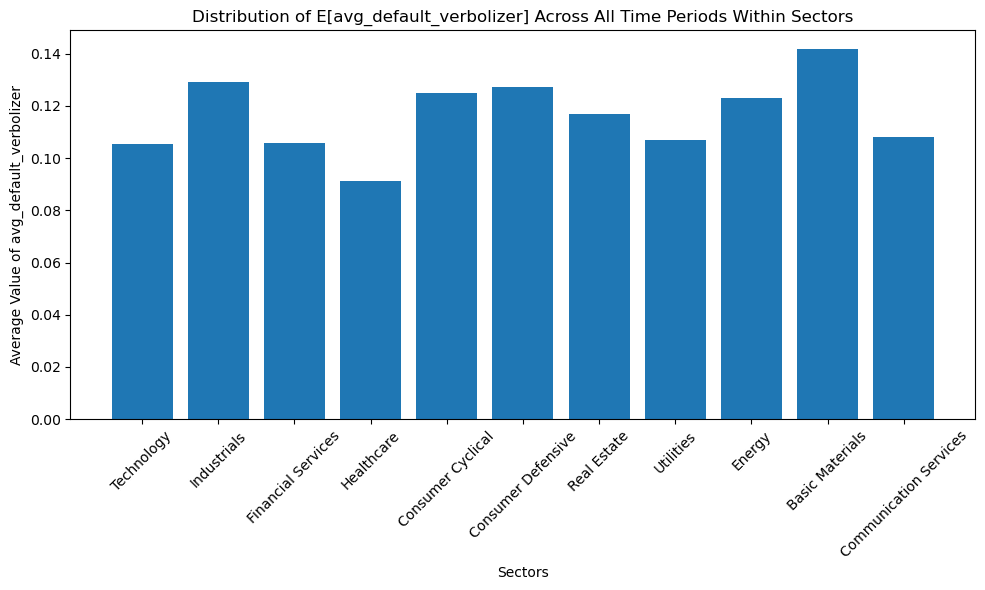

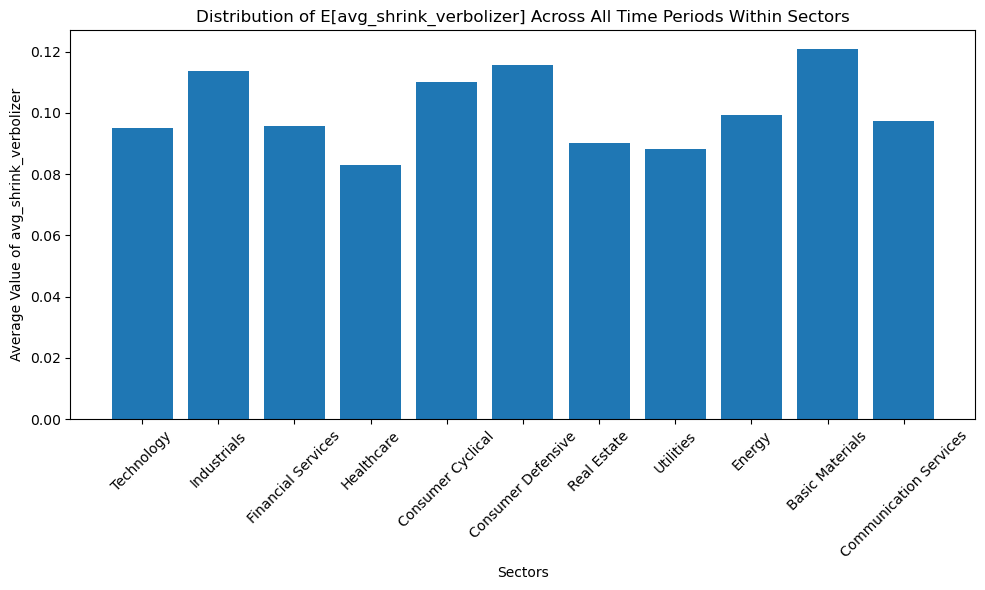

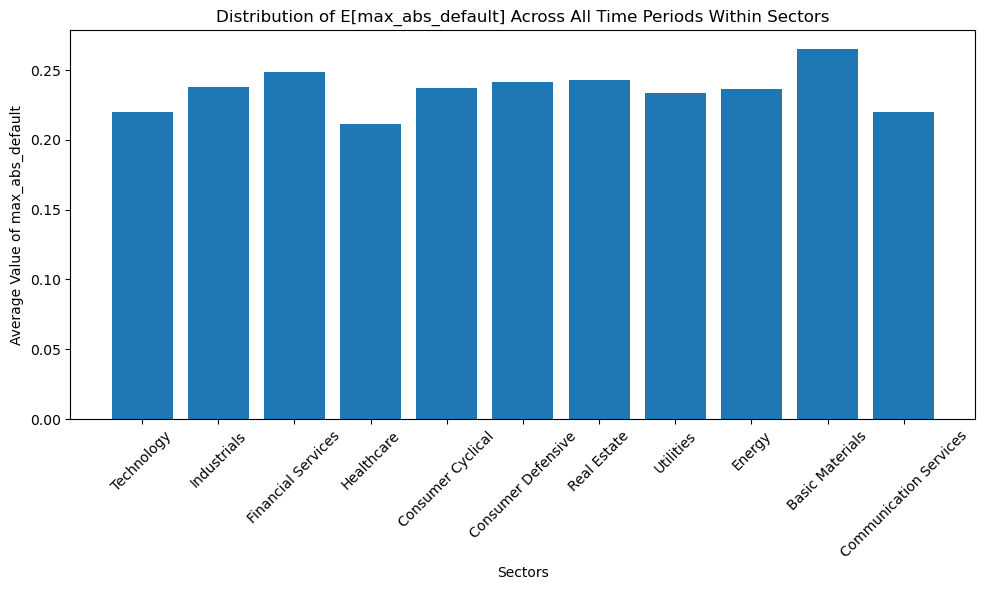

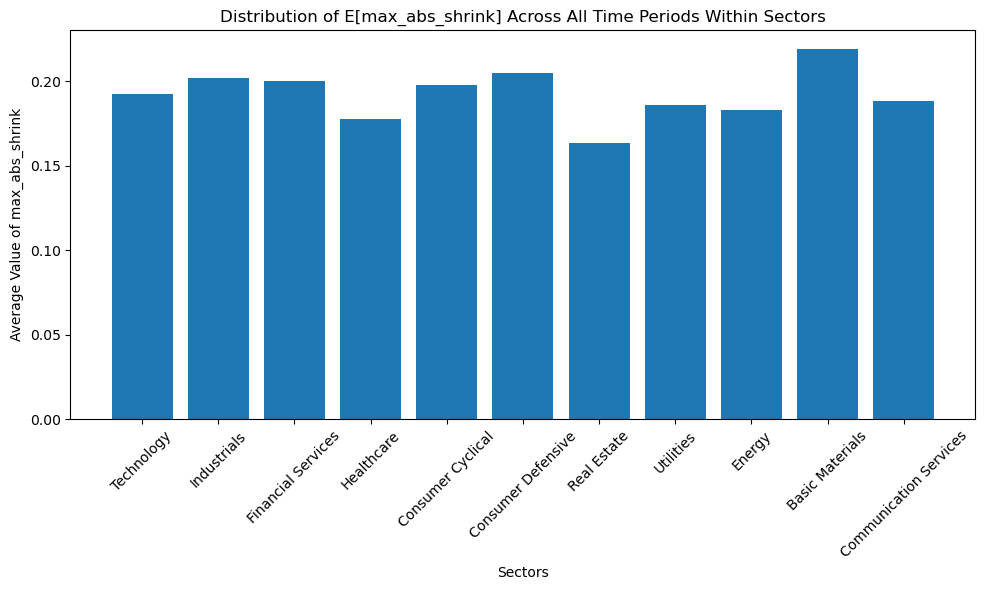

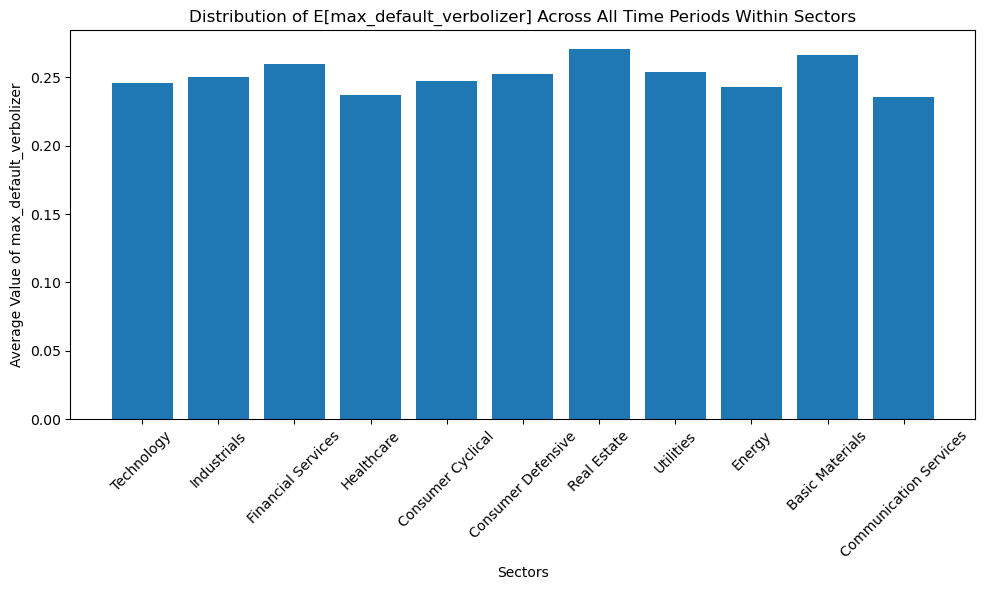

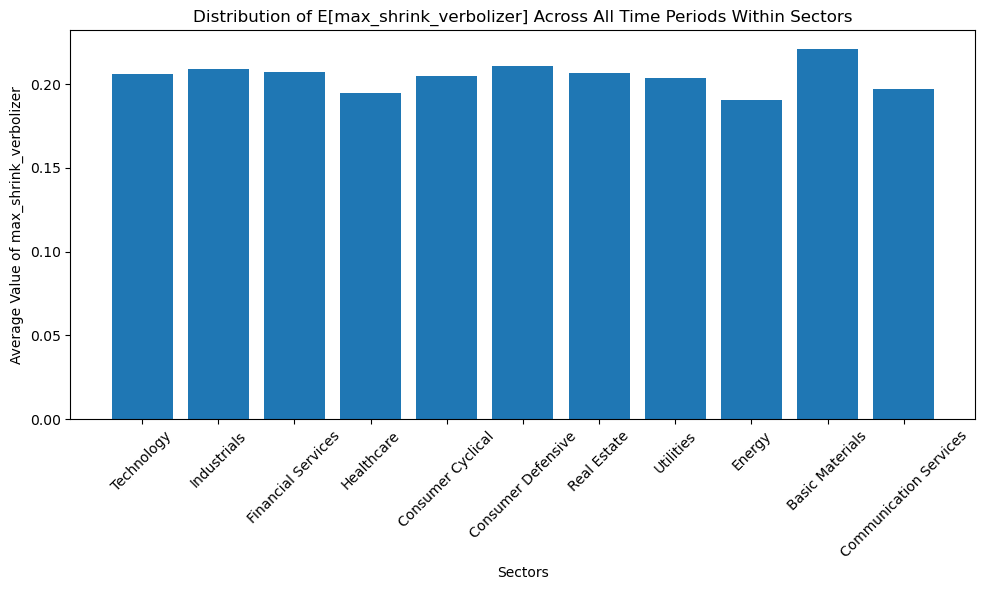

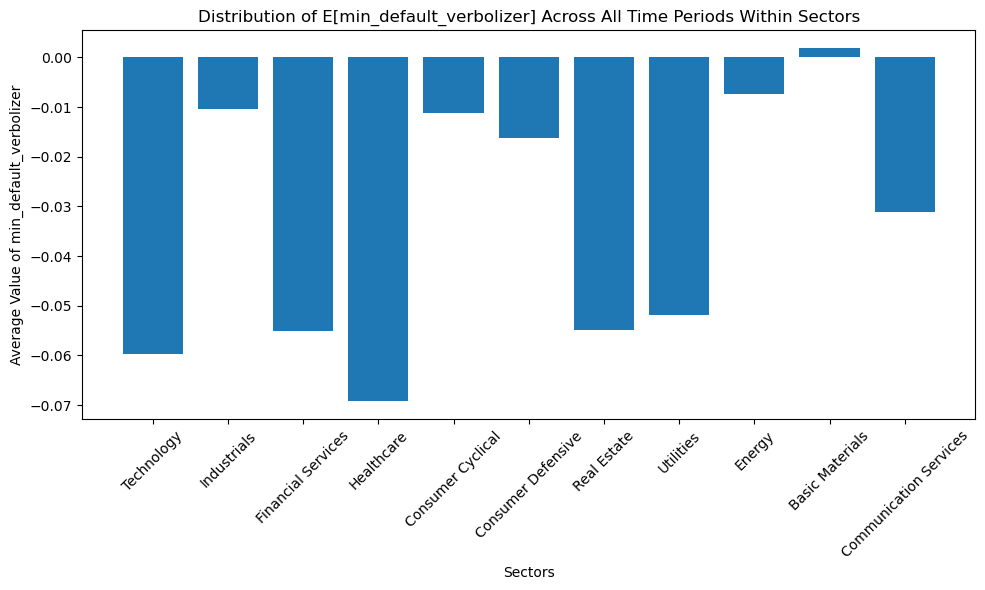

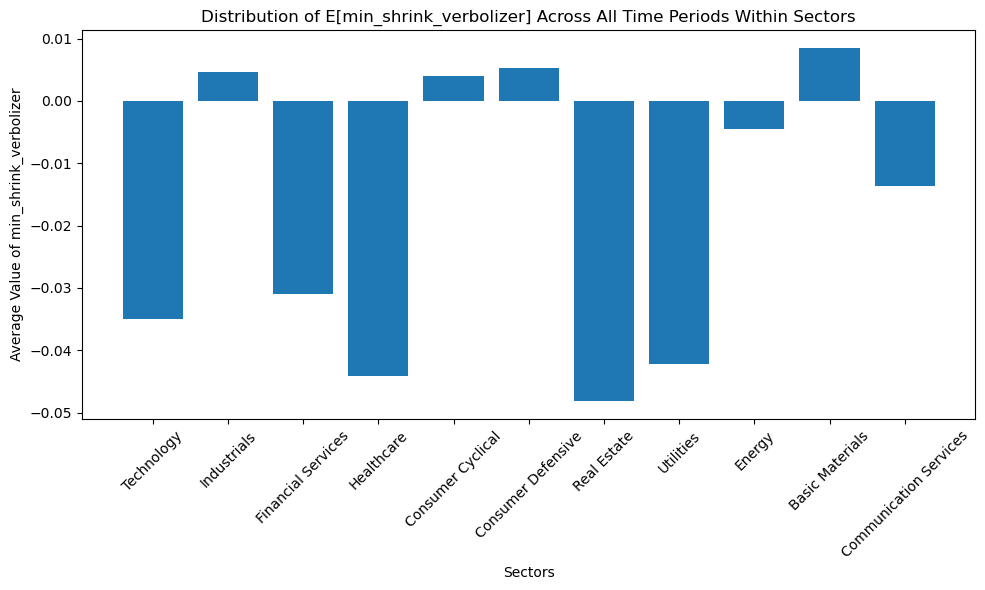

In [42]:
for reg in reg_dict:

    sec_dict_avg = reg_dict[reg]

    keys = list(sec_dict_avg.keys())
    values = list(sec_dict_avg.values())

    plt.figure(figsize=(10, 6))
    plt.bar(keys, values)
    
    # Labeling
    plt.xlabel('Sectors')
    plt.ylabel(f'Average Value of {reg}')
    plt.title(f'Distribution of E[{reg}] Across All Time Periods Within Sectors')
    plt.xticks(
        rotation=45,
        fontsize=10
    )   
    plt.tight_layout()
    plt.show()
    